In [1]:
import json
import math
import numpy as np
#from numpy.fft import fft,ifft
from sklearn.metrics import mean_squared_error
#import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator,LogLocator,MultipleLocator
from matplotlib.dates import SecondLocator
from matplotlib import ticker

#from mpl_toolkits.mplot3d.axes3d import get_test_data
import pprint
from scipy import stats
import datetime
import iso8601
import csv
import re

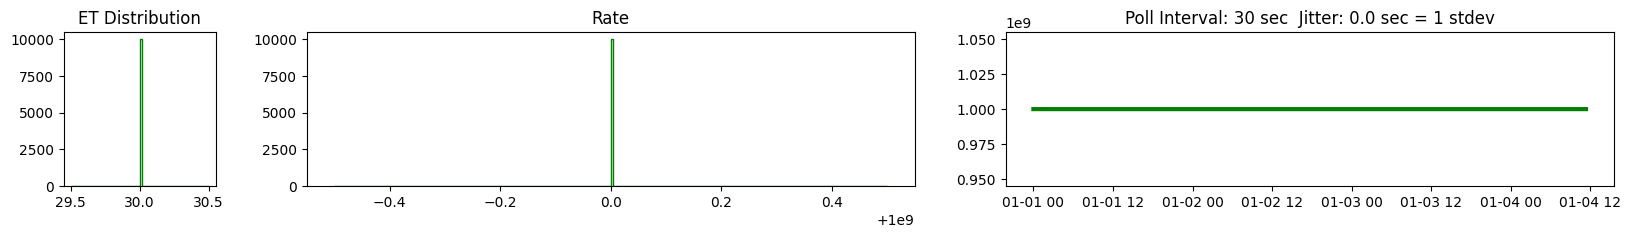

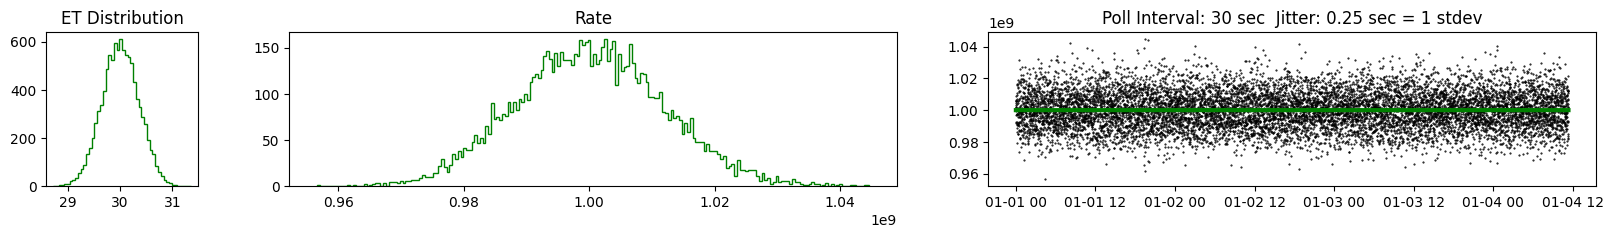

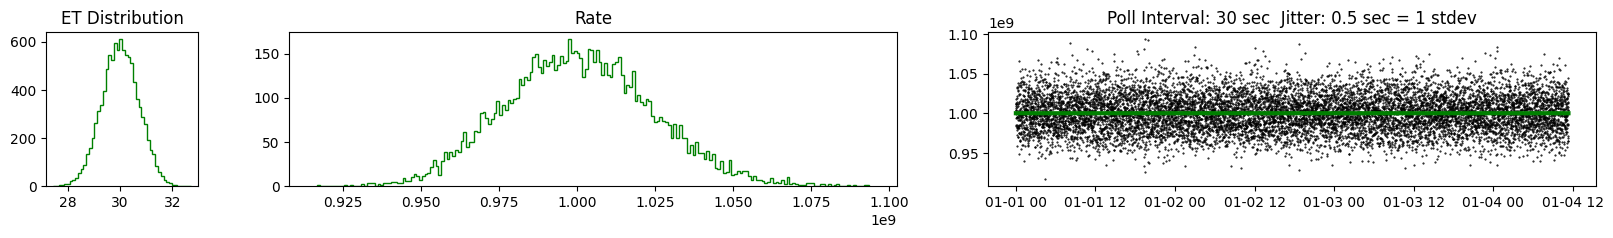

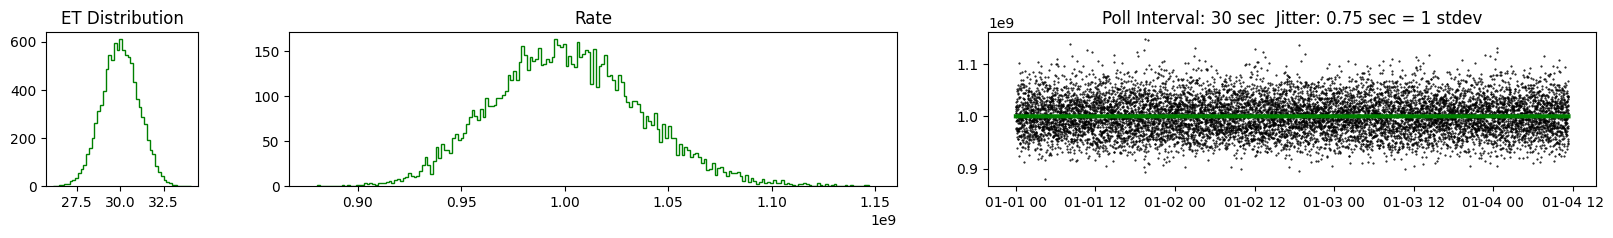

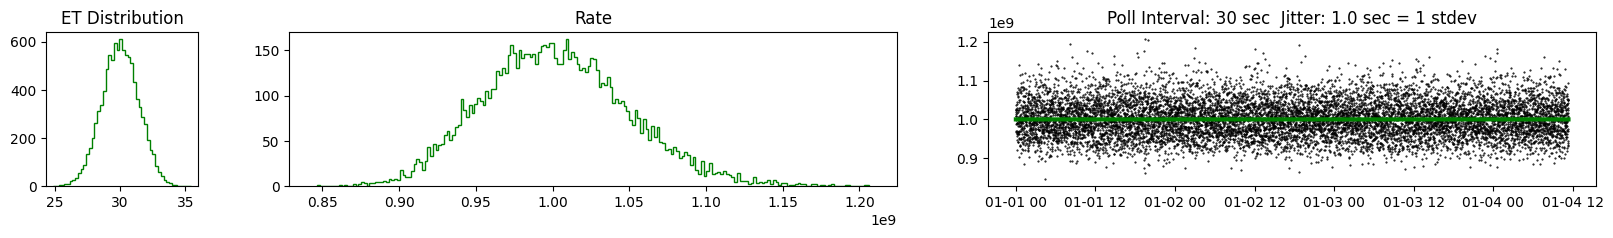

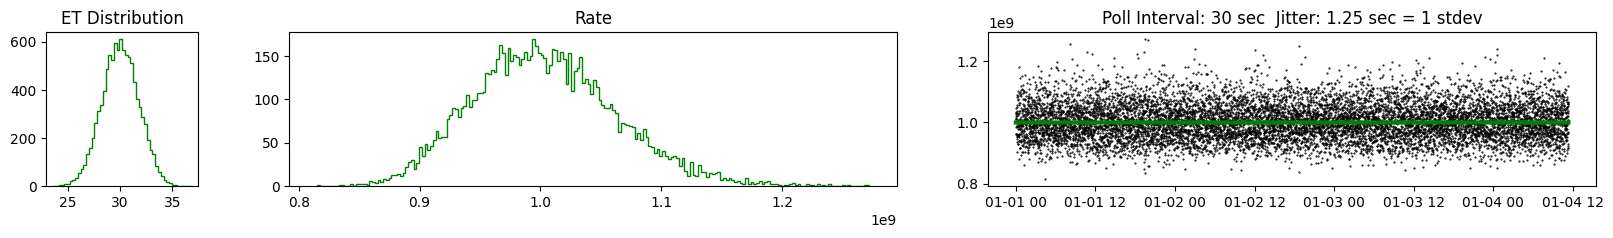

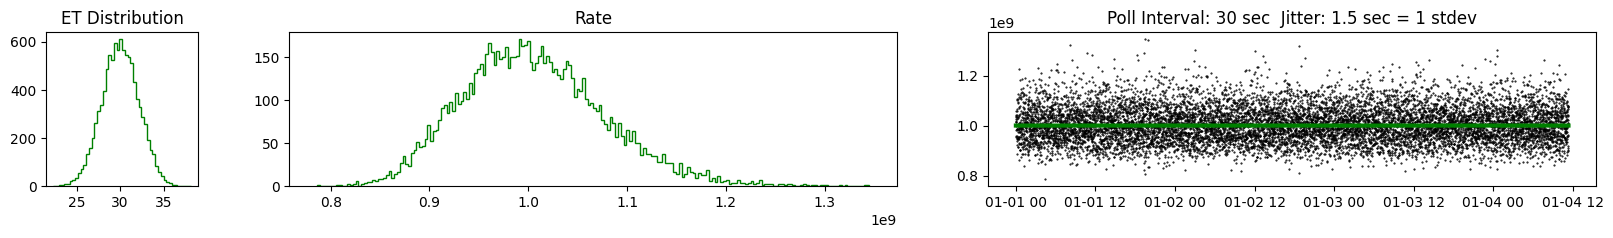

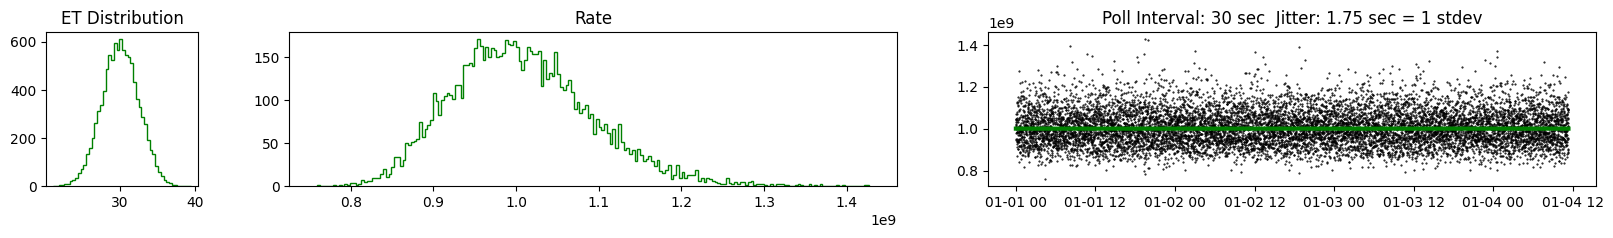

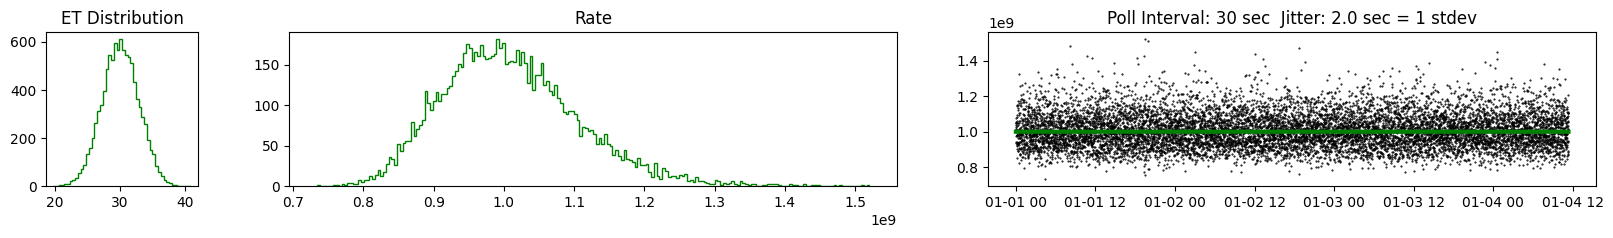

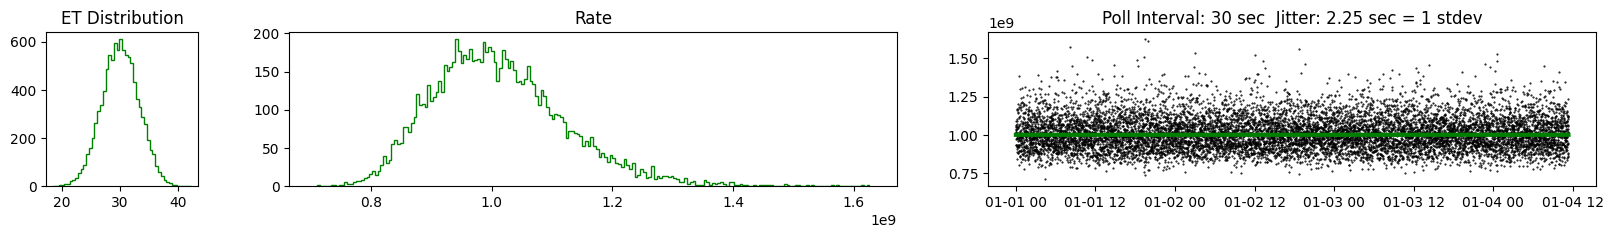

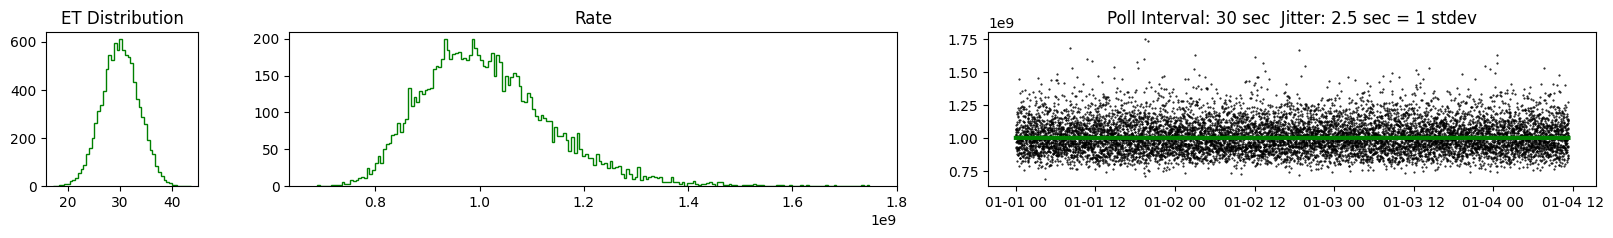

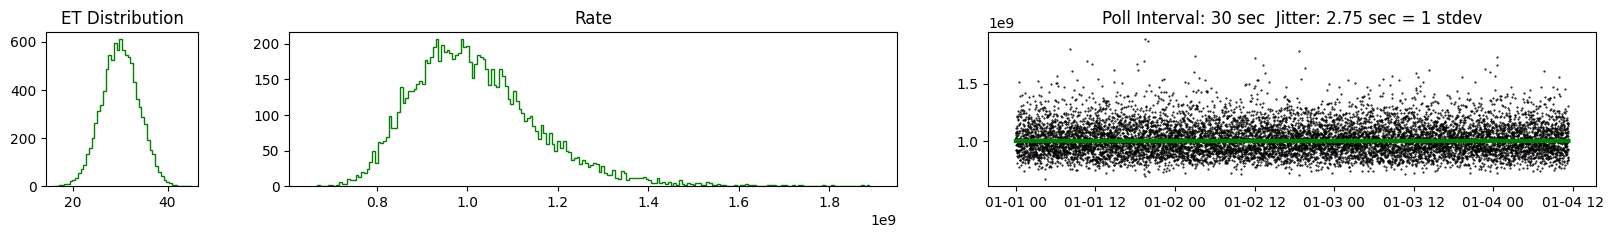

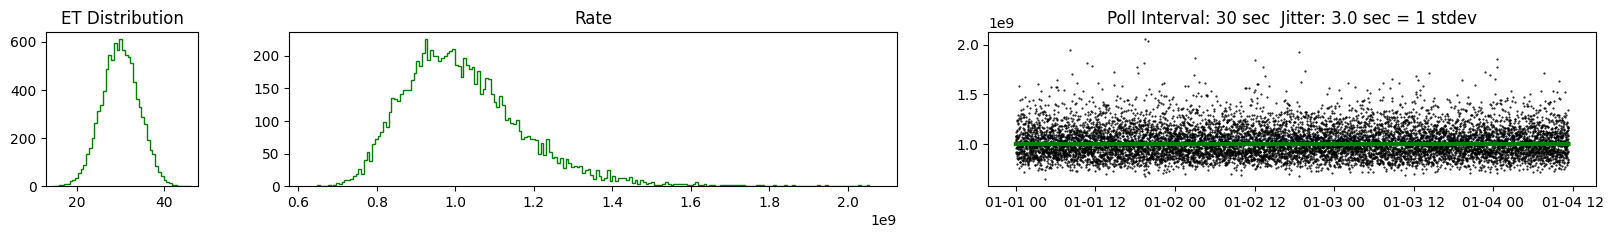

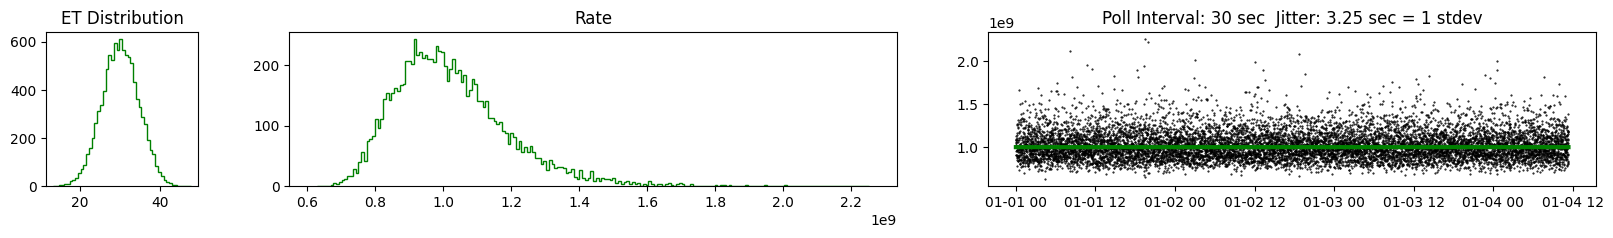

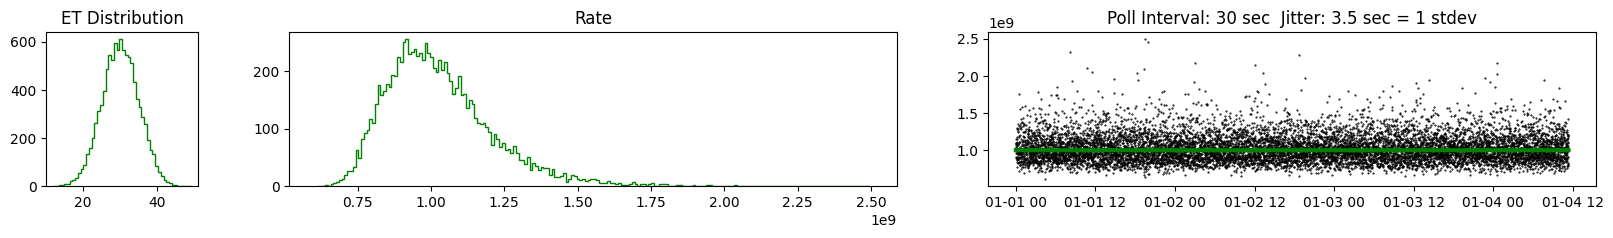

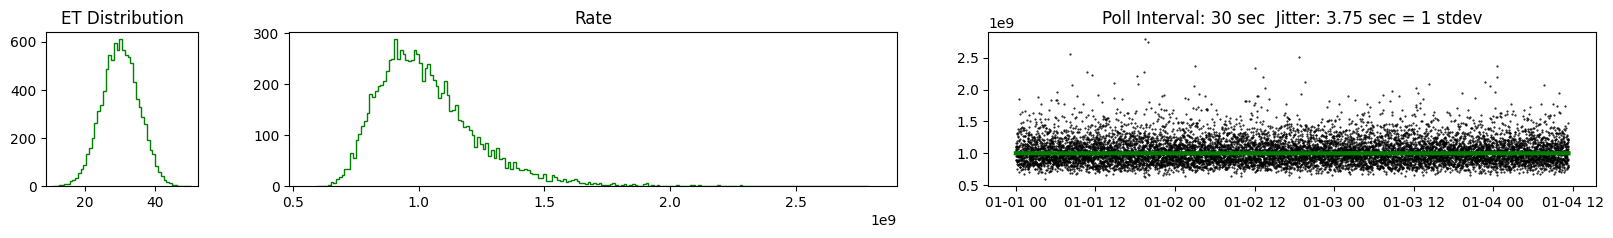

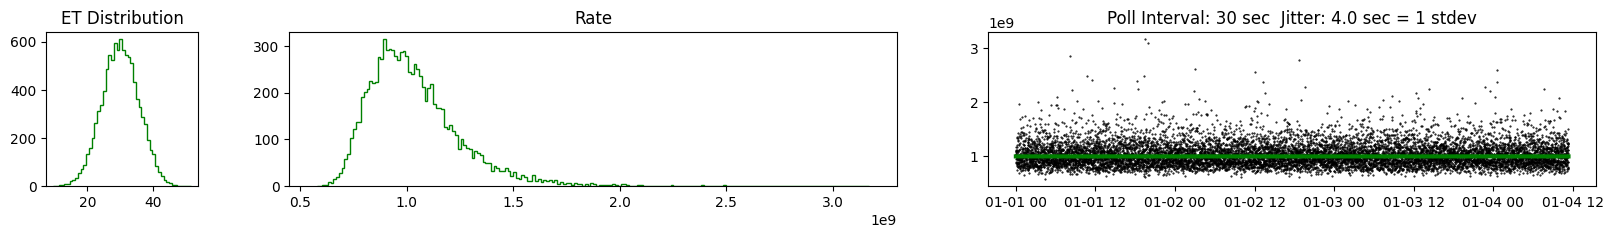

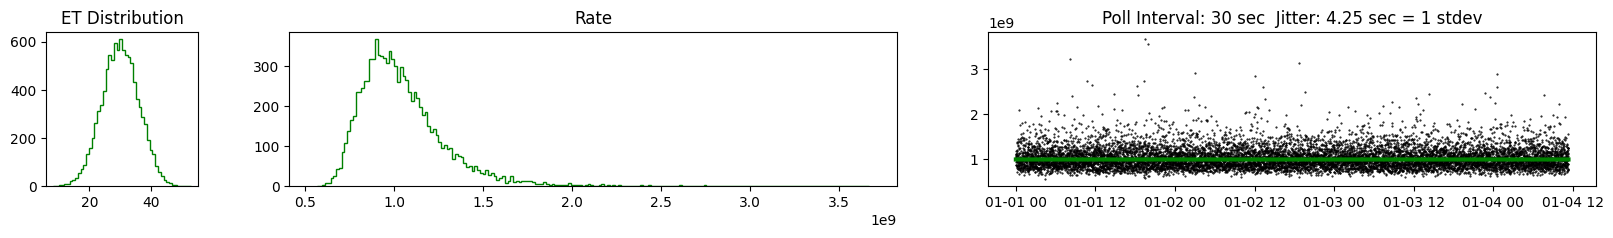

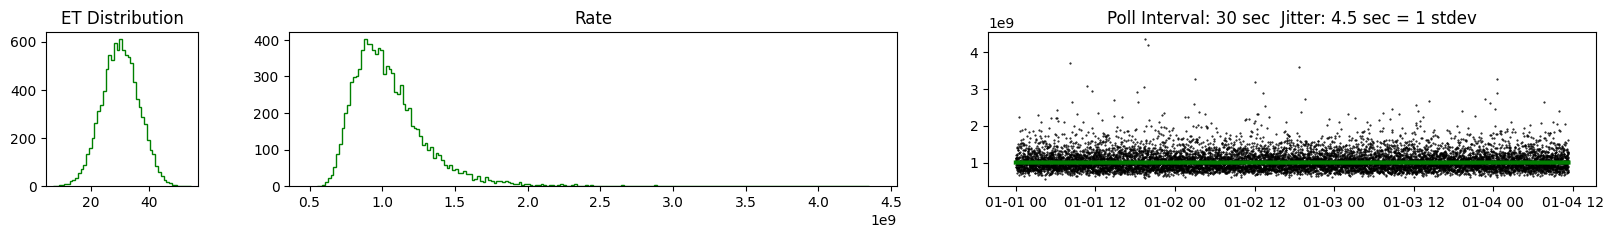

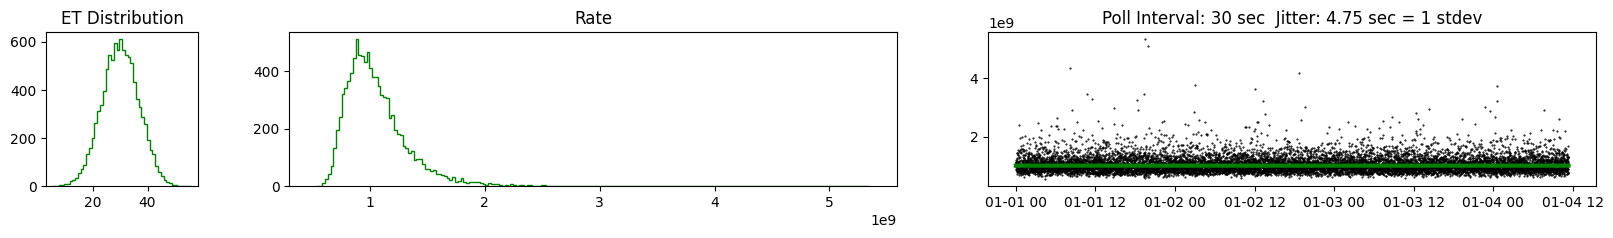

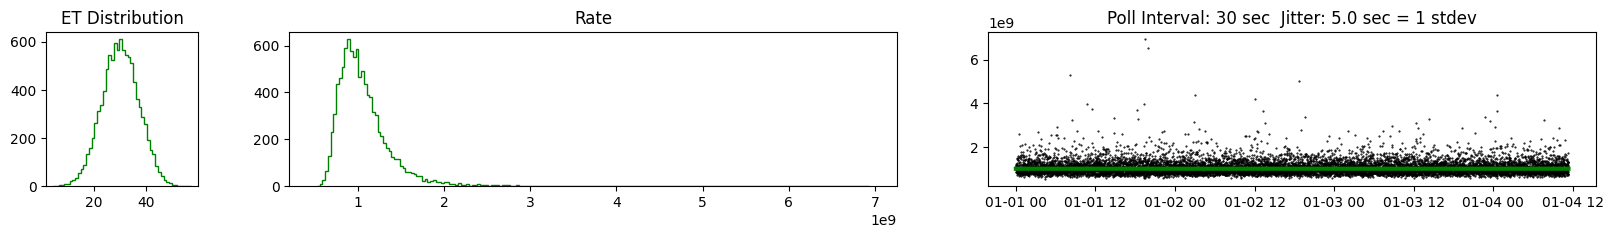

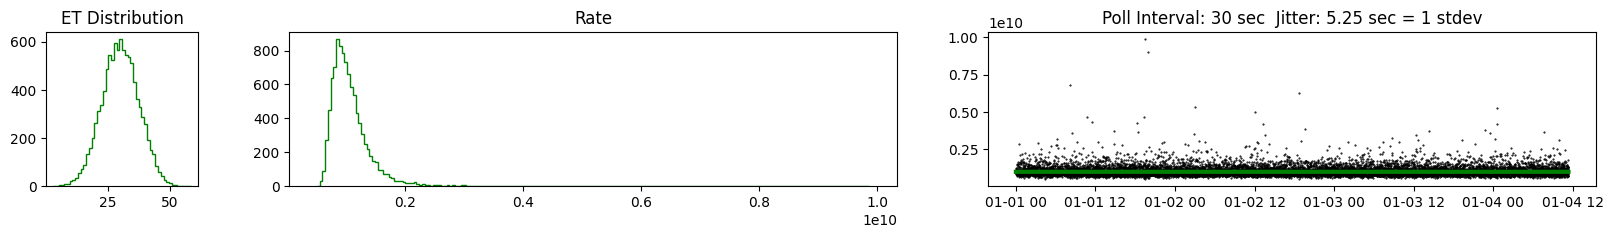

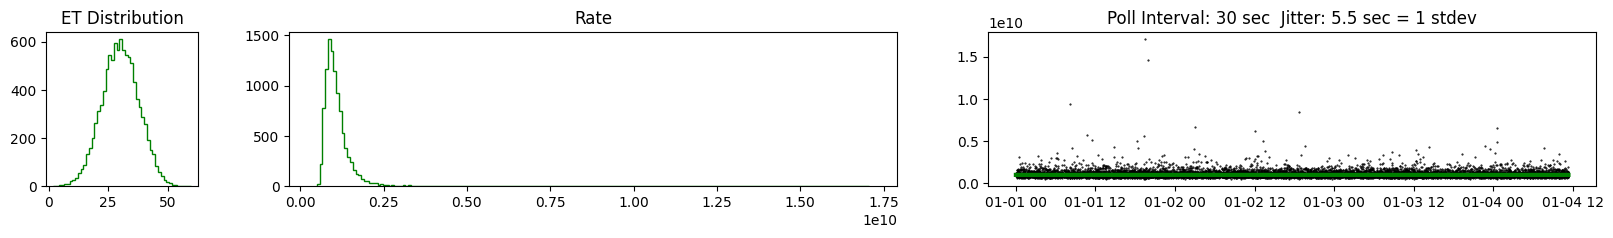

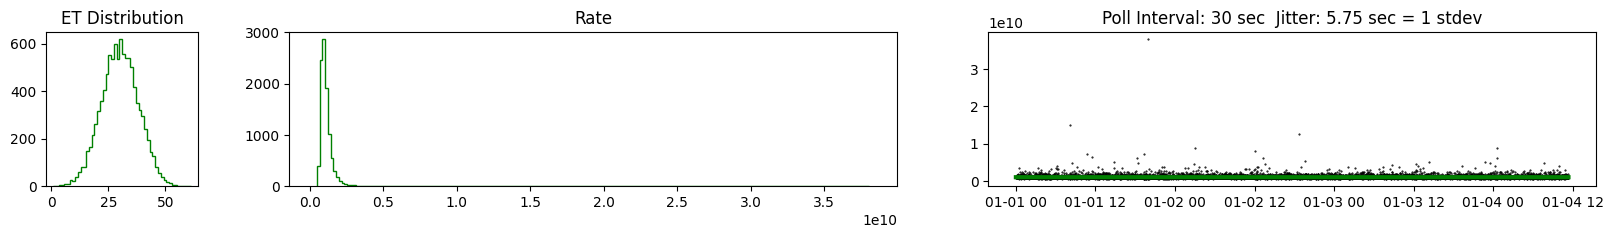

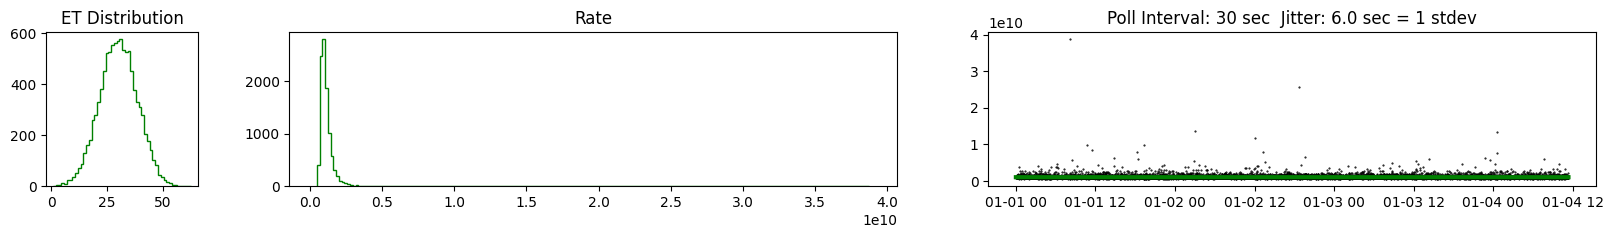

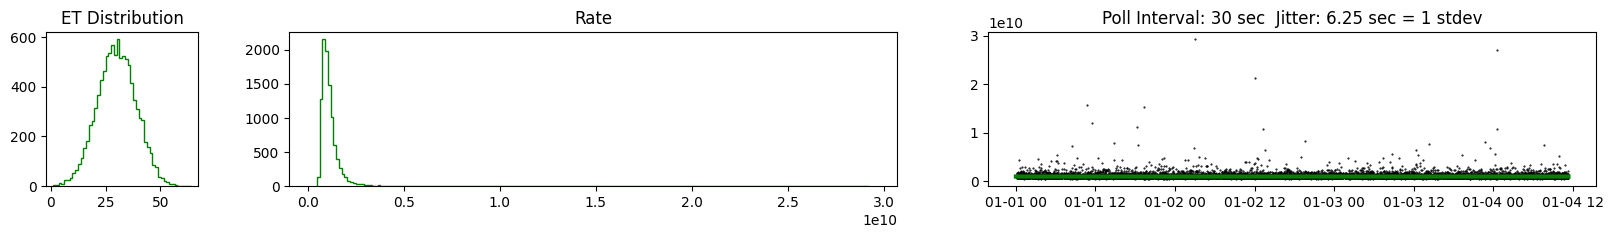

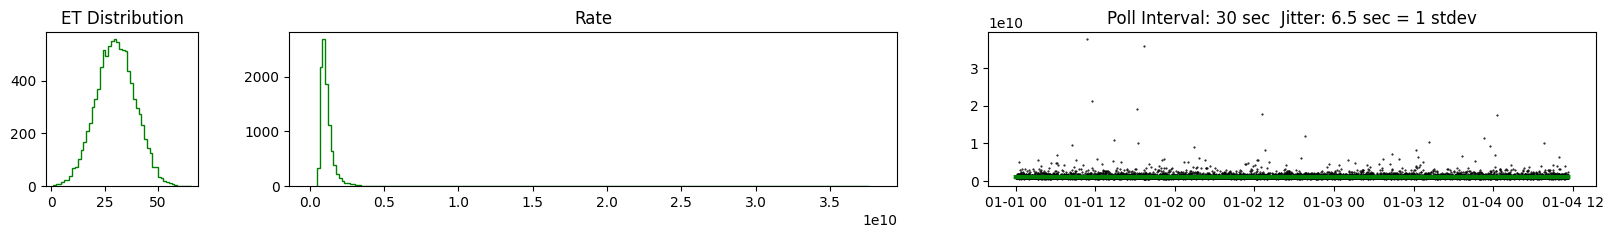

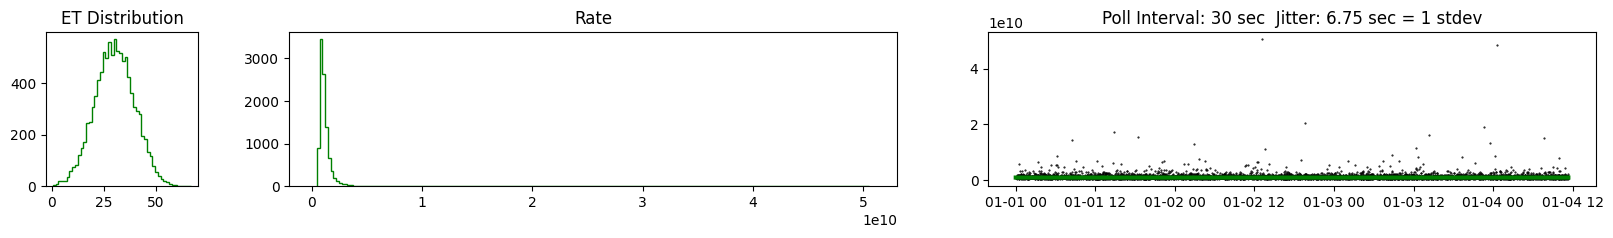

In [2]:
def genTime(row,interval):
 
  timeVal = row['time2_var']
  if timeVal < (interval * -1):
    return row['time'] - pd.Timedelta(interval,unit='S')     
  elif(timeVal > interval):
    return row['time'] + pd.Timedelta(interval,unit='S')     
  else:
    return pd.Timedelta(timeVal,unit='S') + row['time']

def genSeries(rate_per_sec,poll_interval,samples,tv):
  rate = rate_per_sec * poll_interval
  df =  pd.DataFrame()
    
  #---- build the ideal set of data with zero jitter
  df['time']         = pd.to_datetime(np.arange(1,samples*poll_interval,poll_interval),unit='s')
  df['counter']      = np.arange(1,samples*rate,rate)
  df['tv']           = tv
  df['interval']     = poll_interval

    
  #--- now build the set with jitter and thus mesurement error
  df['time2_var']    = np.random.default_rng(seed=1973).normal(0,tv,samples)
  df['time2']        = df.apply(genTime,axis=1,interval=poll_interval)
  df['time2_diff']   = df['time2'].diff() /  np.timedelta64(1,'s')

  #--- make sure time cant go backwards or go inpossibly fast, if its whack... treat the sample like its lost
  bogusData = df[df["time2_diff"] < 0.5]
  df.drop(bogusData.index,inplace=True)

  

  #--- after deleting samples need to rerun anything that depends on diff
  df['time_diff']    = df['time'].diff() / datetime.timedelta(milliseconds=1) / 1000
  df['counter_diff'] = df['counter'].diff() 
  df['rate']         = (df['counter_diff'] / df['time_diff'])


  df['rate2'] = df['counter_diff'] / df['time2_diff']

  #goofy = df[df['rate2'] > 10*rate_per_sec]
  #if goofy.size > 0:
  #  display(goofy)

  if 1 and poll_interval==30:
    f,(ax1,ax3,ax4) = plt.subplots(nrows=1,ncols=3,figsize=(20,2),gridspec_kw={'width_ratios':[1,4,4]})
    ax1.hist(df['time2_diff'],bins=50,density=False,cumulative=False,histtype='step',color='green')
    ax3.hist(df['rate2'],bins=200,density=False,cumulative=False,histtype='step',color='green')
  
    ax1.set_title('ET Distribution')
    ax3.set_title('Rate')
    #ax3.set_yscale('log')

    ax4.plot(df['time2'],df['rate2'], '.',ms=1,linewidth=0,color='black')
    ax4.plot(df['time'],df['rate'],linewidth=3,color='green')
  
    ax4.set_title('Poll Interval: '+str(poll_interval)+' sec  Jitter: '+str(tv)+" sec = 1 stdev")
    plt.show()

  #--- calculate root mean square to characterize  error
  mse = np.square(np.subtract(df.iloc[1:]['rate'].tolist(),df.iloc[1:]['rate2'].tolist())).mean() 
  rmse =  math.sqrt(mse)
  if rmse > 0:
    rmsp = ((rmse*1.0) / rate_per_sec) *100
  else:
    rmsp = 0  

  max = df['rate2'].agg(['max'])
  min = df['rate2'].agg(['min'])
    
  return rmsp,max,min



df = pd.DataFrame(columns=['interval','tv','max','min','rms'])

intervals = [5,10,30,60,5*60]
for poll_int in intervals:
  for tv in np.arange(0,7,.25):
    rms,max,min = genSeries(1000000000,poll_int,10000,tv)
    df.loc[len(df)] = {'interval':poll_int, 'tv':tv,'max':max.to_numpy()[0],'min':min.to_numpy()[0],'rms':rms}
    
    
#df.reset_index(inplace=True)
#df.set_index('tv', drop=False, inplace=True)

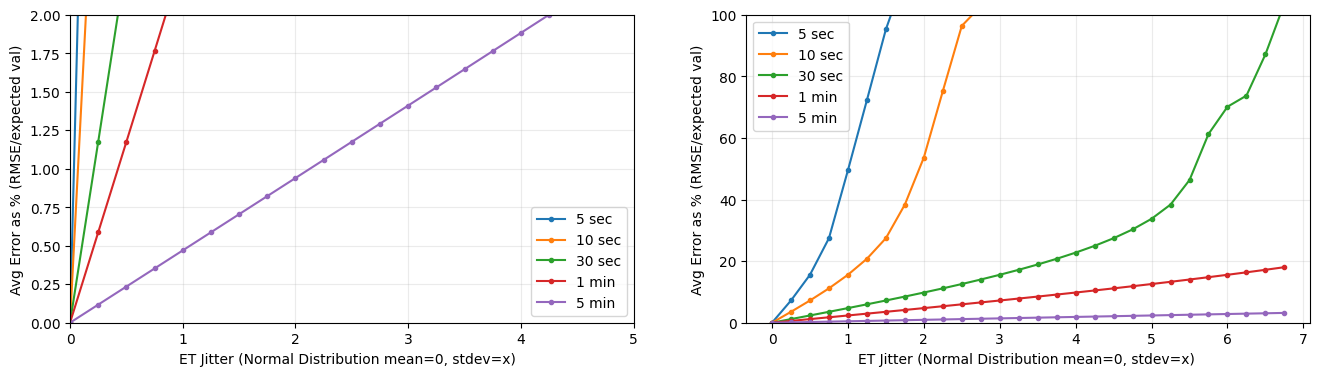

In [3]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))

def fmt_y(x, pos):
    return f'{((x / 1000) *100) - 100: .1f}%'

ax[0].set_ylim(0,2)
ax[0].set_xlim(0,5)
ax[0].grid(axis='both', alpha=.25)
#ax[0].set_yticks(np.arange(0,5,.5))
ax[0].set_xlabel('ET Jitter (Normal Distribution mean=0, stdev=x)  ')
ax[0].set_ylabel('Avg Error as % (RMSE/expected val)')

ax[1].set_ylim(0,100)
ax[1].grid(axis='both', alpha=.25)
#ax[1].set_yticks(np.arange(0,50,2.5))
ax[1].set_xlabel('ET Jitter (Normal Distribution mean=0, stdev=x) ')
ax[1].set_ylabel('Avg Error as % (RMSE/expected val)')

t = df[df['interval']==5]
ax[0].plot(t['tv'],t['rms'],label='5 sec',marker='.')
ax[1].plot(t['tv'],t['rms'],label='5 sec',marker='.')

t = df[df['interval']==10]
ax[0].plot(t['tv'],t['rms'],label='10 sec',marker='.')
ax[1].plot(t['tv'],t['rms'],label='10 sec',marker='.')

t = df[df['interval']==30]
ax[0].plot(t['tv'],t['rms'],label='30 sec',marker='.')
ax[1].plot(t['tv'],t['rms'],label='30 sec',marker='.')

t = df[df['interval']==60]
ax[0].plot(t['tv'],t['rms'],label='1 min',marker='.')
ax[1].plot(t['tv'],t['rms'],label='1 min',marker='.')

t = df[df['interval']==300]
ax[0].plot(t['tv'],t['rms'],label='5 min',marker='.')
ax[1].plot(t['tv'],t['rms'],label='5 min',marker='.')

ax[0].legend()
ax[1].legend()

